# The Numerical Taxonomy of Urban Form

## Why should we care about urban form?

Cities need to transform dramatically to become __more livable, resilient, sustainable and just__, whilst continuing to offer economic stability.

The  built environment is herein often only viewed as a __passive component__, yet it, too, constitutes an __active layer__ which affects the sustainability, quality of life and modes of existence in urban environments and can directly or indirectly be manipulated through design and planning (Fleischmann 2021).


Previous studies were able to showcase the (often significant) __impact__ of urban morphology on various aspects of __environmental, social and economical performance__ of cities. This includes, but is not limited to:
- Energy demand
- Wind energy potential
- Urban (micro) climate
- Noise
- Carbon emissions
- Health
- Vibrancy
- Walk/Bikeability
- Urban planning

## Urban form is diverse, complex and ever evolving - but how do we measure it?

<div align="center">
<img src="../documents/images/urban_form_patterns.jpg" width="1000"/>
</div>

<p style="text-align: center;">
    <a href="https://doi.org/10.1111/gean.12302">Source: Fleischmann, M., Feliciotti, A., Kerr, W., 2021. Evolution of Urban Patterns: Urban Morphology as an Open Reproducible Data Science</a>
</p>

The study of urban form is anchored in the discipline of __urban morphology__ which in summary aims to answer the following questions:

>_“What the urban form is like, why the urban form is like that, and then how could we make the urban form better for people?”_ - Michael Barke (Northumbria University – Department of Geography and Environment)

Traditionally, the methods of urban morphology are __qualitative in nature__.

With rapid development in the realm of __Geographic Data Science__, quantitative approaches are gaining momentum.

Spearheading the developments are highly specialised researchers working on open-source and highly reproducible approaches to studying urban morphology. GUI software based approaches are usually hard to replicate, and often not adaptable to a specific case. This is not true for code-based approaches such as the one in the use case.

---

## What we are doing today: Calculating urban form indicators. 

We will generate the taxonomy of urban form for a dutch city, calculating morphology indicators and idenitfying clusters of urban form characteristics based on <a href="https://doi.org/10.1177/23998083211059835">Fleischmann, M., Feliciotti, A., Romice, O., Porta, S., 2022. Methodological foundation of a numerical taxonomy of urban form. Environment and Planning B: Urban Analytics and City Science 49, 1283–1299. </a>

<div align="center">
<img src="../documents/images/ams_taxonomy.jpg" width="1200"/>
</div>

__Why are we interested in this in the first place?__

> If we can characterising urban form in a reproducible and scalable way, it will allow us to explore the relationship between different urban spaces and phenomena such as environmental performance (heat, pollution), health (physical/mental) and plenty more...



__Why we need to scale:__ 

- Original code is heavy on resources
- AMS case (~122.000 buildings) -> 3-4 hours of processing in serial.
- We would like to expand this to run for dozens/hundreds of cities (e.g., using the <a href="https://eubucco.com/">European building stock characteristics database (EUBUCCO)</a>, containing about __200 Million__ buildings.)



What we will do is the following: 

<div align="center">
<img src="../documents/images/process.jpg" width="1000"/>
</div>
<p style="text-align: center;">
    <a href="https://doi.org/10.1177/23998083211059835">Source: Fleischmann, M., Feliciotti, A., Romice, O., Porta, S., 2022. Methodological foundation of a numerical taxonomy of urban form. Environ Plan B Urban Anal City Sci 49, 1283–1299. </a>
</p>

You can find the original code <a href="https://github.com/martinfleis/numerical-taxonomy-paper">here</a>. We rely heavily on a open source library for morphometric analysis authored by Martin Fleischmann as well: <a href="https://docs.momepy.org/en/stable/">Momepy</a>.



There are __3 main hurdles__ to overcome in order to scale this approach:

1. Tessellation
2. Calculating contextual indicators
3. Clustering

We will use different approaches to deal with these issues!

---




## First things first: Why is this analysis fit to scale?

__There are very MINIMAL Inputs required__:

- building footprints (incl. height information) as polygons.
- street network as linestrings.

This is by design, allowing us to replicate this approach almost anywhere.

__Keep this in mind for your own analyses. Think: What is the minimal amount of data necessary__

---



## But you were promised the 3DBAG?

We are in fact using it: The 2D building footprints are taken straight from the 3dbag (__rough version of download script is attached - feel free to adapt it for your analyses__).

<div align="center">
<img src="../documents/images/3dbag.png" width="1000"/>
</div>
<p style="text-align: center;">
    <a href="https://3dbag.nl/en/viewer">Source: 3DBAG. </a>
</p>




### 3D in 2D? What?

__There are multiple reasons for this:__
- 3D data is important to address a variety of (urban) challenges. It is, however, difficult to work with. 
- 3D is still a relatively new landscape and tools are far less developed. We are still working on a lot of the foundations (the not so shiny stuff that is hidden under the iceberg)
- There are some resources on 3D morphology - even using the 3DBAG (<a href="https://doi.org/10.1080/13658816.2022.2103818">Labetski, et. al 2022</a>), but we couldn't apply these at the scale we're envisioning.

<div align="center">
<img src="../documents/images/iceberg.png" width="400"/>
</div>
<p style="text-align: center;">
    Source: Stoter 2022
</p>

__However, more importantly:__
- We would like to scale this approach to the entire EU building stock, maybe beyond. While we have high quality 3D building models in NL, this is not the case everywhere.
- Building height information is quite frequently available, in the EU for ~75% of the <a href="https://eubucco.com/">building stock</a>.

Bottom line for you: 

__The 3DBAG does not only contain 3D data, but also 2D tiles (with added characteristics like building height).__ 

AND

__Not every use case requires a true 3D dataset__. Know that using 2D polygons with height\ information is always an option, and might be enough depending on what your analysis requires.

Always: If you have any questions, or need some help. <a href="https://3d.bk.tudelft.nl/">Please get in touch with me or any of my colleagues.</a>

## Let's finally get started. Step 1: Import modules/libraries

In [1]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

# Import all relevant libraries/modules
import operator 
import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np

import pandas as pd
import scipy as sp

import seaborn as sns

import folium

import dask
import os

from dask.distributed import Client
from dask import delayed
from dask.diagnostics import ProgressBar
from scipy.cluster import hierarchy
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

# To show all columns in a dataframe. To reset: pd.reset_option(“max_columns”)
pd.set_option('display.max_columns', None) 

# Set the correct path to the datasets
try:
    path = os.environ["SCALABLE_GIS_DATA_PATH"]
except KeyError:
    path = "/project/stursdat/Data/ScalableGIS/Part1/"
    

## Step 2: Load and prep buildings

In order to finish in time, we will be working with a sample of the AMS dataset - feel free to follow along with any of the city districts (Stadsdeel)

In [2]:
# Loading Amsterdam neighbourhoods and keeping only one region of interest:
ams = gpd.read_file(path+'AMS_Buurten_lnglat.json').to_crs(28992)
ams = ams.loc[(ams['Stadsdeelcode']  == 'A')] # ['A'] == Amsterdam center, other values are: ['E' 'M' 'K' 'F' 'N' 'S' 'B' 'T']
# ams = ams.loc[(ams['Wijkcode']  == 'AJ')]  # If you want to run this for a very small spatial unit, such as the Wijk. You can also try other codes eg AJ01
ams.explore(tiles='CartoDB positron')

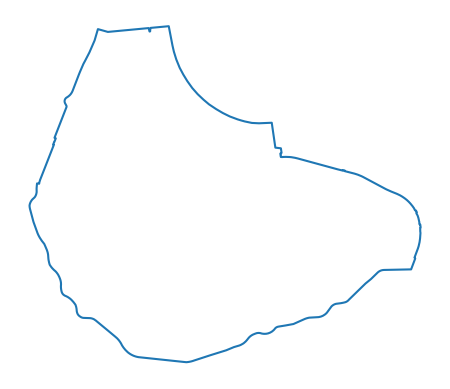

In [3]:
# Get just the outline, we will need this later.
ams_outline = ams.dissolve().boundary
ax = ams_outline.plot()
ax.set_axis_off()

Number of buildings 15844.


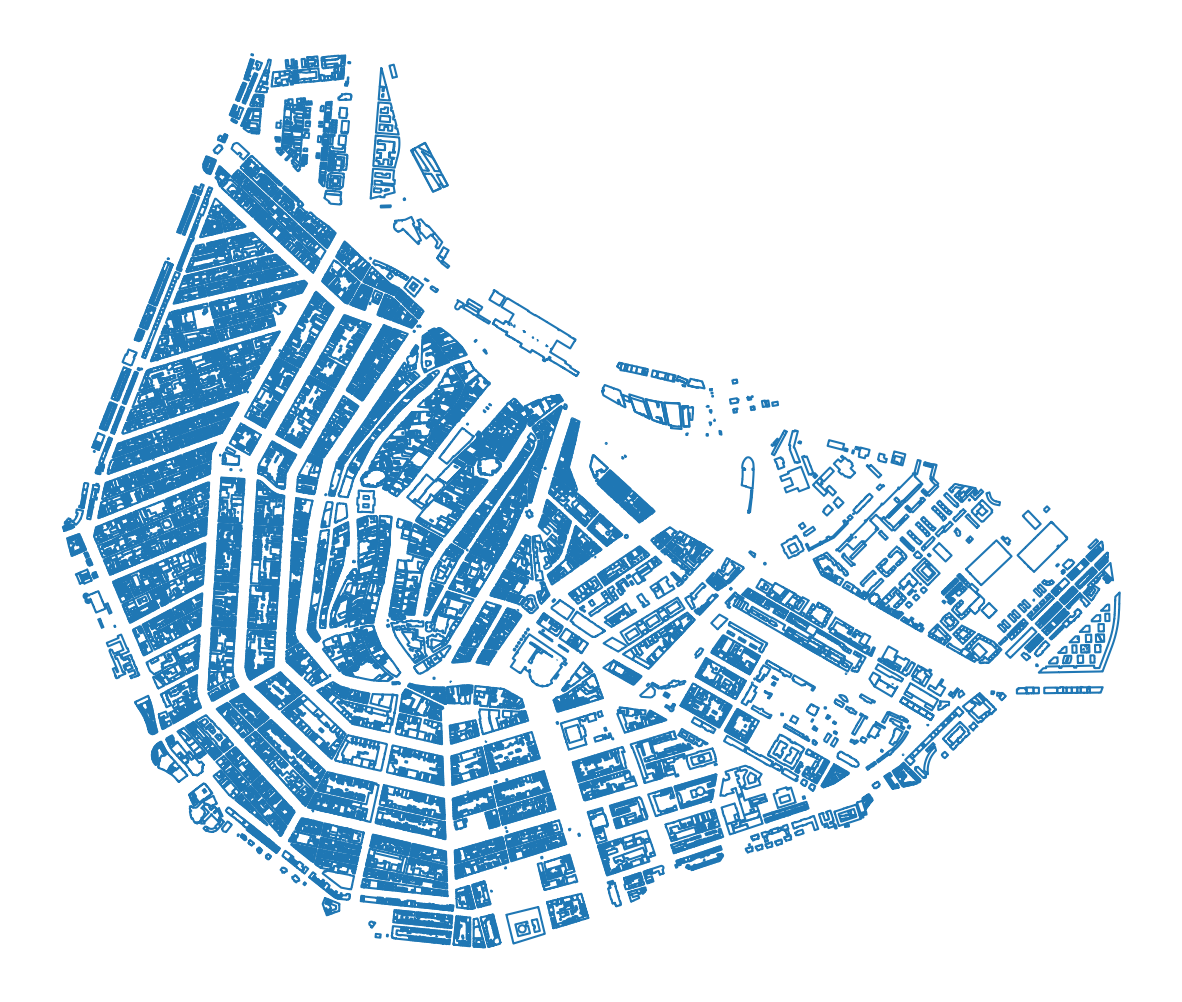

In [4]:
# Loading all amsterdam buildings and keeping only the ones within the selected unit
buildings = gpd.read_file(path+"3DBAG/Amsterdam_buildings.gpkg", mask = ams)
buildings = buildings.clip(ams)
buildings = buildings[['height_70p','geometry']]
print(f"Number of buildings {len(buildings)}.")
ax = buildings.boundary.plot(figsize=(15,15))
ax.set_axis_off()

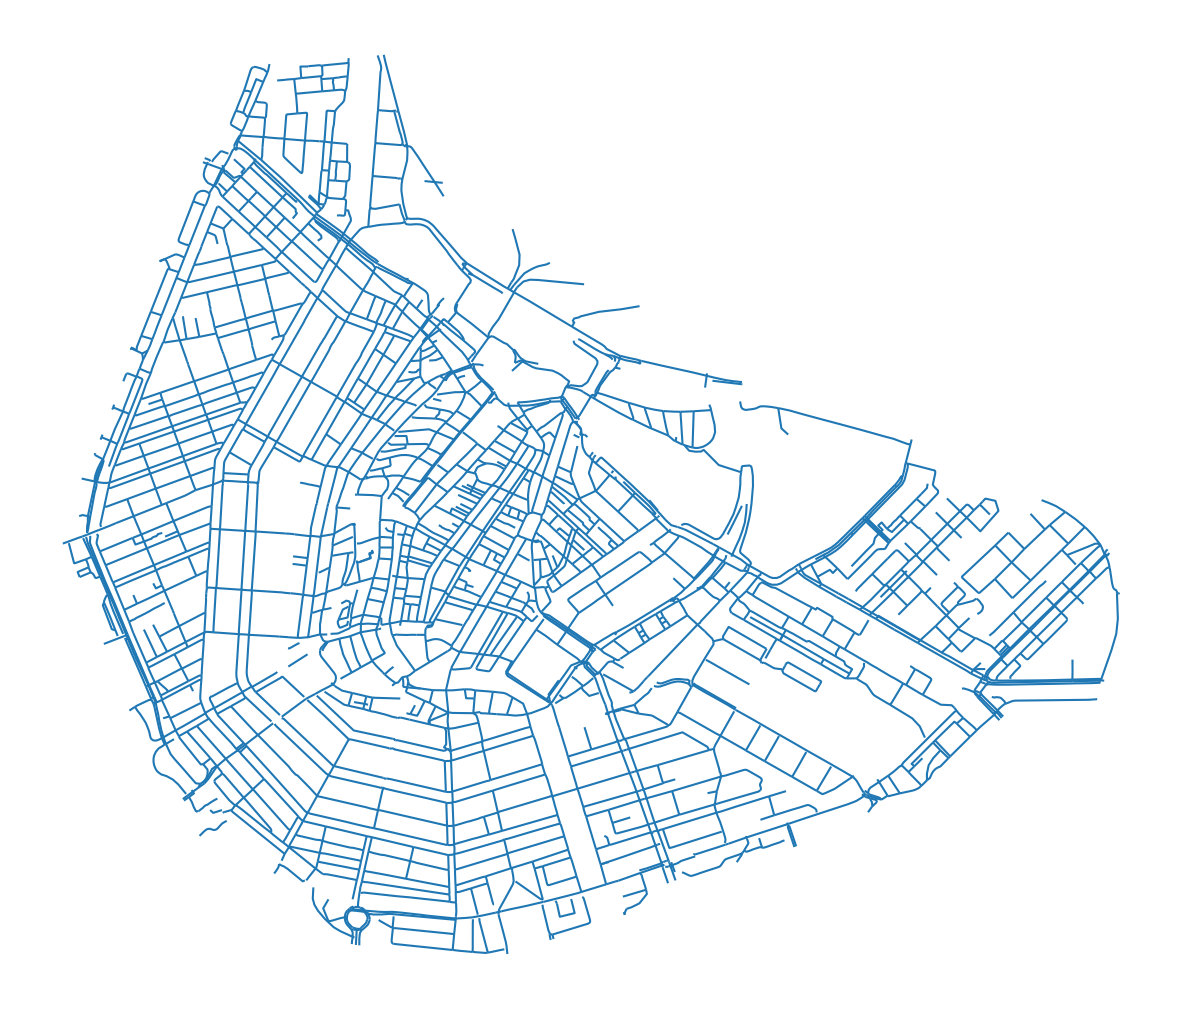

In [5]:
# Loading street network and keeping only the ones relevant to the chosen neighbourhood
streets = gpd.read_file(path+'/Wegvakken/Wegvakken.shp', mask = ams).to_crs(28992)
streets = streets.clip(ams)
streets = streets[streets['FRC'].isin(['1','6'])]
streets = streets[['geometry']] # keep only the geometry column
streets = streets.explode(ignore_index=True) 
ax = streets.plot(figsize=(15,15))
ax.set_axis_off()

__Let's clean up the dataframe and create a persistent unique identifier for each building__
- Clean up the dataframe. Discard small structures (sheds, etc.) and potential sources of error.
    - If the feature area is smaller than the set size it will be 
        a) deleted if it does not touch any other feature; 
        b) joined to the feature with which it shares the longest boundary. If feature is fully within other feature, these will be joined. If feature’s circular compactness (momepy.CircularCompactness) is < 0.2, it will be joined to feature with which it shares the longest boundary. Function does multiple loops through.
- Building height was already calculated prior to this - the 3DBAG comes with different calculated heights.
- We use 70th percentile height because it most accurately represents the true height of the building. 

In [6]:
%%time
# Preprocess buildings (clean up small buildings that are likely uninhabitable, and eliminate multipolygons)
buildings = mm.preprocess(buildings, size=30, compactness=0.2, islands=True, loops=2, verbose=True)
assert not buildings.duplicated().any() # Make sure there are no duplicates
# Create a persistent unique identifier for each building
buildings = buildings.reset_index(drop=True)
buildings["uID"] = buildings.index
buildings.head()



Loop 1 out of 2.


Identifying changes:   0%|          | 0/15844 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/30 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/14357 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

CPU times: user 4.73 s, sys: 141 ms, total: 4.87 s
Wall time: 4.87 s


height_70p                                           geometry  uID
0   15.032204  POLYGON ((121534.361 485712.676, 121534.045 48...    0
1   18.461202  POLYGON ((121537.804 485712.924, 121537.922 48...    1
2    3.213964  POLYGON ((121525.142 485730.014, 121528.859 48...    2
3   15.695476  POLYGON ((121524.436 485724.944, 121524.416 48...    3
4   15.632582  POLYGON ((121510.551 485716.459, 121511.091 48...    4

## Step 3: Generate additional morphometric elements (First scalability hurdle)

Morphology is usually comprised of three fundamental elements: _buildings, plots, streets_. 

We have buildings and streets, but plots are more complicated because they can have a variety of different configurations and meanings (e.g., multiple buildings on a single plot).

So how do we generate this missing element, respecting contiguity and keeping data reliance at a minimum (remember, we would like to scale this and would like to only have building footprints and roads)?:

__Morphological Tessellation (based on voronoi tessellation)__

<div align="center">
<img src="../documents/images/Euclidean_Voronoi_diagram.svg.png" width="200"/>
</div>
</div>
<p style="text-align: center;">
    <a href="https://en.wikipedia.org/wiki/Voronoi_diagram">Source. </a>
</p>


The "morphological cell" (the result of the tessellation), is a spatial unit capturing the portion of land around each building which is closer to it than any other, but no further than 100m.

It is used to capture the relations between cells and the influence of a building on the surrounding space.

### The first scalability hurdle:


Momepy includes two approaches to tessellation: __Morphological tessellation__ and __enclosed tessellation__.


The original approach utilises morphological tessellation, which is produces good results, but is painfully slow (> 45 minutes to tessellate AMS) and __NOT easily scalable__!

Let's have a look:

This is the result of the serial implementation. As you can see, everything looks neat and tidy. Tessellation cells are maybe a little bit too large due to the maximum distance of 100m.

<div align="center">
<img src="../documents/images/morph_tessellation.png" width="1000"/>
<!-- <figcaption align = "center"> Serial Implementation </figcaption> -->
</div>
<p style="text-align: center;">
    Morphological Tessellation - Serial
</p>

To run this in parallel we would have to chunk the operation somehow. If we try this and run it in parallel, this is what we get:

<div align="center">
<img src="../documents/images/morph_tessellation_parallel.jpg" width="1000"/>
</div>
<p style="text-align: center;">
    Morphological Tessellation - Parallel
</p>


__So what is the issue here?__

On the outer limit it looks like the original function. 

__BUT__

The function requires awareness of surrounding buildings, so the __overlap__ becomes an issue.

No easy way to fix the geometries and get to a desirable result.


### So how do we get around this? We adapt the method and switch to: __Enclosed Tessellation__

We break down the tessellation into a two-step process.

1. We use our existing information on 'boundaries' (street network, study area boundary) to partition the space into 'enclosures'.
<div align="center">
<img src="../documents/images/outline_roads.png" width="1000"/>
</div>
<p style="text-align: center;">
    Enclosures based on street network (blue) and administrative boundary (black)
</p>
2. Once the space is divided up, we can chunk the morphological tessellation and apply it to each enclosure. 

Why does this allow parallelisation? Each enclosure can be handled separately and does not require awareness of neighbouring enclosures to divide up the space!

__But how do these results compare?__

<div align="center">
<img src="../documents/images/comparison_tessellation.png" width="1000"/>
</div>
<p style="text-align: center;">
    Comparison of morphological (blue) and enclosed tessellation (red 
</p>

#### What do we take away from this?

- Enclosed tessellation more closely resembles actual plots! 
- Because we can run the process in parallel, the computation takes only a fraction of the time. 

__Learning__: When selecting/developing your method, keep in mind that you need to be able to chunk it into parts to take advantage of parallel processing!

Let's be transparent: A remaining issue is that enclosed tessellation works best with simplified road geometry (centrelines), which we don't have. Thus we have more 'empty' tessellation cells than we should have.


### 3.1 Enclosed tessellation (Parallel)

Let's get to it:

A quick reminder, we've already loaded 
- buildings
- streets
- waterways (as additional barrier for enclosures)

First step: Check our input for tessellation. If the input data is clean, this check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [7]:
check = mm.CheckTessellationInput(buildings, shrink=0.05)
print(f"The problematic buildings are {check.split['uID'].values} and the overlapping ones {check.overlap['uID'].values}")

Collapsed features  : 0
Split features      : 19
Overlapping features: 68
The problematic buildings are [  443   831  1168  1289  1642  2243  2819  2855  3733  4031  4459  4925
  5290  7018  7037  8467  9266 12697 13987] and the overlapping ones [ 2009  2010  2117  2118  4080  4082  4694  4695  5002  5003  6247  6251
  6462  6463  6547  6592  6631  7101  7102  8225  8226  8310  8321  8330
  8331  8332  8333  8334  8335  8336  8337  8338  8339  8354  9140  9146
  9492  9493  9915  9919 11073 11607 11610 12733 13054 13055 13063 13064
 13260 13261 13264 13265 13562 13563 13564 13677 13683 13684 13685 13690
 13691 13692 13693 13694 13711 13712 14216 14217]


As you can see, we do have some split and overlapping features. We will simply acknowledge this for now. 

Next we create the enclosures for tessellation.

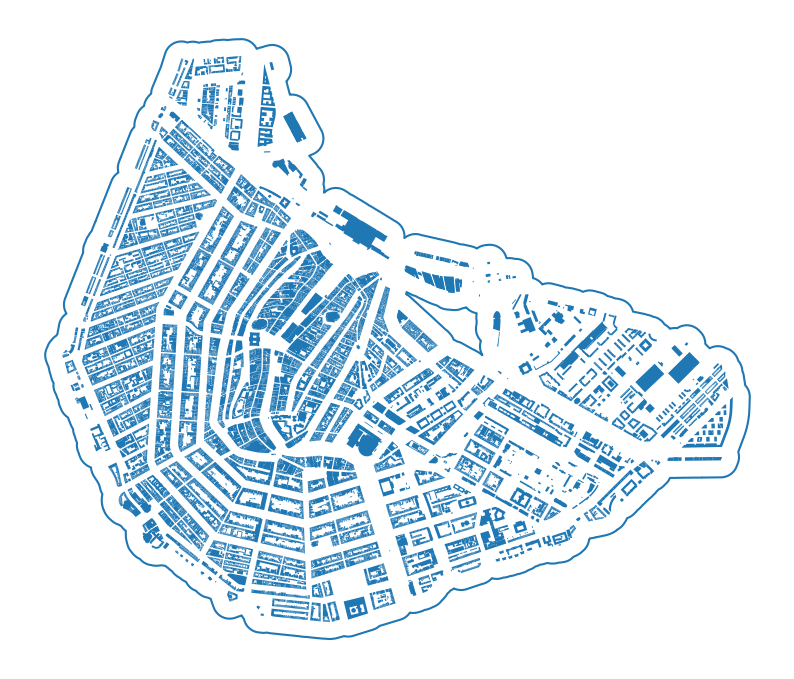

In [8]:
## Define a limit for the tessellation by adding a buffer around the buildings
limit = mm.buffered_limit(buildings, buffer=100)
limit = gpd.GeoSeries([limit])

# Set the limit crs to building crs.
limit.set_crs(crs=buildings.crs, inplace=True)

# Plot results
ax = limit.boundary.plot(figsize=(10,10))
buildings.plot(ax=ax)
ax.set_axis_off()

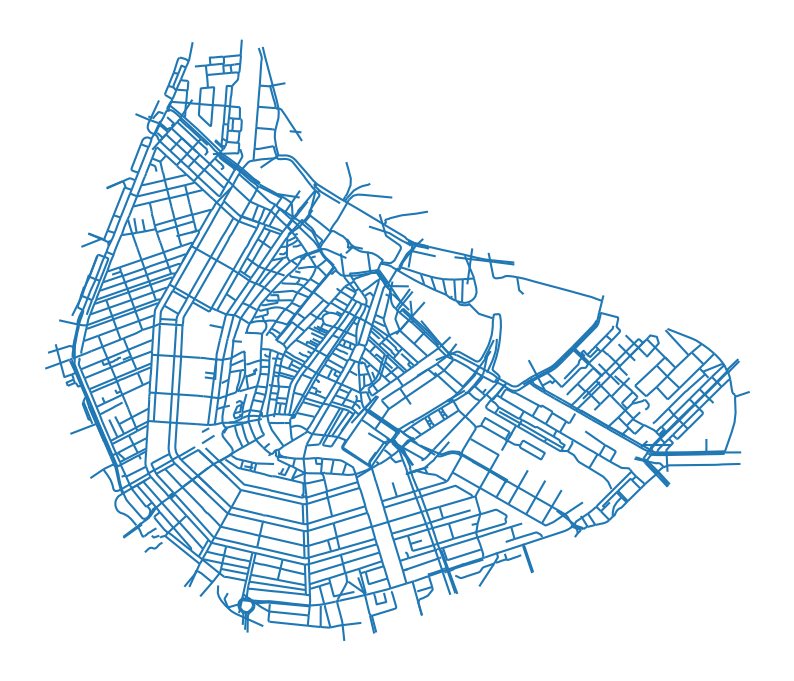

In [9]:
# Extend streets from gdf to itself or target within a set tolerance. With this we close potential gaps, taking care not to extend through buildings.
extended_streets = mm.extend_lines(streets, tolerance=120, target=limit, barrier=buildings)

# Plot results
ax = extended_streets.plot(figsize=(10,10))
ax.set_axis_off()

/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Amersfoort / RD New (the single non-null crs provided).
  warnings.warn(


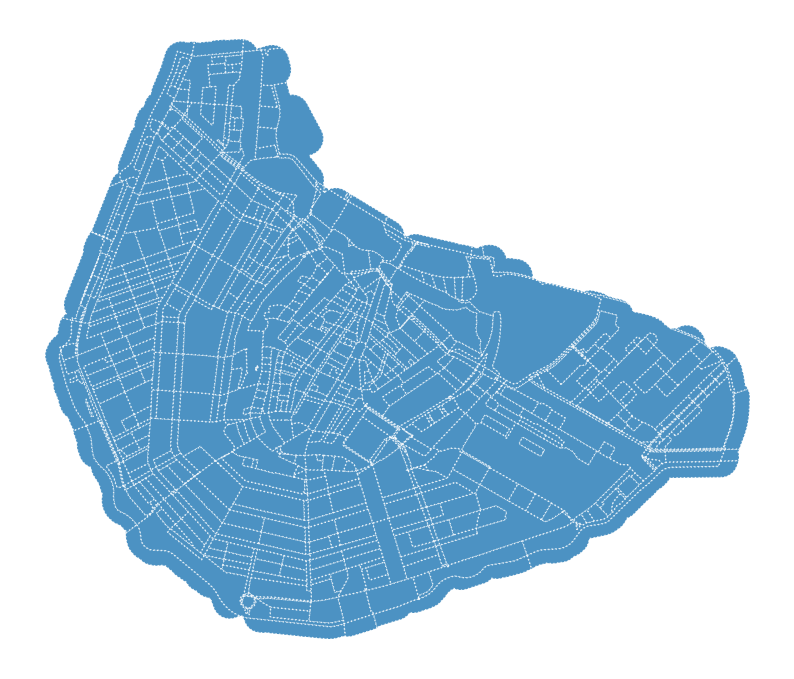

In [10]:
# Generate enclosures, creating the chunks for tessellation. Ignore the userwarning!
enclosures = mm.enclosures(primary_barriers=extended_streets, additional_barriers=[ams_outline], limit=limit)

# Plot results
ax = enclosures.plot(edgecolor='white',linestyle='dotted', alpha=.8, figsize=(10,10))
ax.set_axis_off()

__Create a dask client__
If you are working on SURF: use the dask cluster manager on the left

In [11]:
# These are the specs for the workshop. If you work on this yourself, increase the number of workers depending on resources available to you.
client = Client(n_workers=2, threads_per_worker=4)
client

<Client: 'tcp://127.0.0.1:53577' processes=2 threads=8, memory=16.00 GiB>

/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 17.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-05-21 20:12:16,296 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-21 20:12:16,747 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-21 20:12:17,123 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-21 20:12:17,813 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-21 20:12:18,263 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-21 20:12:19,465 - distributed.utils_perf - WARNING - full g

CPU times: user 5.87 s, sys: 1.98 s, total: 7.85 s
Wall time: 33.1 s


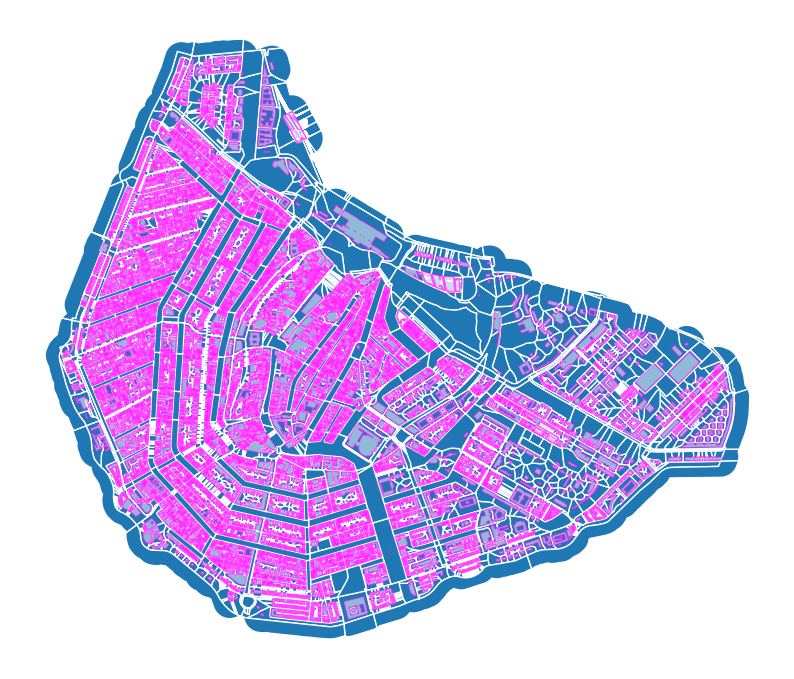

In [12]:
%%time
# Tessellate using the enclosures to chunk the processing. The momepy function already includes a dask implementation and uses the existing client we've set up. 
# Watch the progress in the dask dashboard. Performance improvement over morphological tessellation -> 45m -> 5 m for the entire Amsterdam case.
enclosed_tessellation = mm.Tessellation(buildings, unique_id='uID', enclosures=enclosures, use_dask=True, shrink = 0.1, verbose=True).tessellation

# Some post processing, keep only columns of interest
enclosed_tessellation = enclosed_tessellation[['uID','geometry']]

# Plot results
ax = enclosed_tessellation.plot(figsize=(10, 10), edgecolor='white')
buildings.plot(ax=ax, color='white', alpha=.5, edgecolor='magenta')
ax.set_axis_off()

In [13]:
# Close the dask client (because it is a good practice)
client.close()

In [14]:
######## Post-tessellation Cleaning

#### Deal with empty cells (result of enclosures without buildings)

# If we have empty cells we must give them a 'fake' building id even though they enclose no building
empty_cells_num = len(enclosed_tessellation[enclosed_tessellation.uID.isna()])

if empty_cells_num > 0:
    print(f'We have {empty_cells_num} empty cells')
    print('---------------')

    enclosed_tessellation = enclosed_tessellation.reset_index(drop=True)
    max_uID = int(enclosed_tessellation.uID.max())
    filler = pd.Series(range((max_uID+1), (max_uID+1)+empty_cells_num), index=enclosed_tessellation[enclosed_tessellation.uID.isna()].index)
    enclosed_tessellation['uID'] = enclosed_tessellation.uID.fillna(filler)



# Make sure there are no empty cells without ID
assert not enclosed_tessellation.uID.isna().any()
print('Empty Cells fixed')

enclosed_tessellation['uID'] = enclosed_tessellation['uID'].astype(int)

print('---------------')

#### Deal with duplicated/split Cells: 

# I.e: when 1 building belongs to more than one cells.
# We would expect 1-to-1 relationship between the buildings and the cells but we sometimes find duplicates. 
# This is the effect of the shrinking applied during the tessellation method
# Shrinking might cause a building footprint to split into two or more polygons,
# resulting in the same number of cells.
# These cells are merged (dissolve)

enclosed_tessellation = enclosed_tessellation.dissolve(by='uID', as_index=False)

# Make sure there are no more duplicates
assert not enclosed_tessellation['uID'].duplicated().any()
print('Buildings with double cells fixed.')


print('---------------')

# Fixes a small error in tessellation
building_filter = list(enclosed_tessellation.uID.loc[enclosed_tessellation.uID.isin(list(buildings.uID))])
buildings = buildings.loc[buildings.uID.isin(building_filter)].copy()
print('Building DataFrame clean')


We have 494 empty cells
---------------
Empty Cells fixed
---------------
Buildings with double cells fixed.
---------------
Building DataFrame clean


In [ ]:
# Plot the results interactively
e = enclosed_tessellation.explore(tiles='CartoDB positron')
e

### 3.2 Tessellation and street based blocks

__Building blocks__ are another morphological element we take into consideration in the further analysis. In order to generate them, we take the tessellation results, the extended road network and the buildings.

The function dissolves the tessellation cells containing buildings based on the street network and then links the resulting ID to buildings and tessellation as attributes.

603 blocks created: 
---------------
CPU times: user 12.6 s, sys: 155 ms, total: 12.8 s
Wall time: 12.8 s


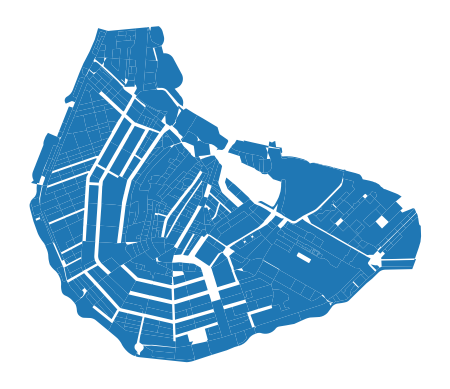

In [15]:
%%time
# Create street blocks
blocks = mm.Blocks(enclosed_tessellation, edges=extended_streets, buildings=buildings, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks 
print(f"{len(blocks.blocks)} blocks created: ") 
print('---------------')
buildings['bID'] = blocks.buildings_id.values  # get block ID
enclosed_tessellation['bID'] = blocks.tessellation_id.values  # get block ID

# Plot results
ax = blocks_df.plot()
ax.set_axis_off()

#### 3.3 Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [16]:
tessellation=enclosed_tessellation.copy() 

# Create network ID's
streets["nID"] = range(len(streets))

# Get network ID's for each individual building
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)

# Merge with tesselation results
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Step 4: Morphometric assessment

Morphometric characters are measurable traits of morphometric elements, such as the length of wings or dimensions of beaks in biology (hence the 'taxonomy' aspect). 

These characters are crucial for cluster analysis and capture the structural complexity of urban tissues across different scales. The numerical taxonomy approach as proposed by Fleischmann utilizes six categories of morphometric characters: dimension, shape, spatial distribution, intensity, connectivity, and diversity.

We differentiate between two different types of characters: _primary_ and _contextual_

Primary characters measure the geometry and configuration of buildings, streets, tessellation cells and blocks and their relationships.

We measure ~70 primary characteristics between the buildings, blocks, tessellation cells and streets. A few examples are:

<table><tr>
<td> <img src="../documents/images/building_indicators.jpg" alt="Drawing" style="width: 500;"/> </td>
<td> <img src="../documents/images/building_context.jpg" alt="Drawing" style="width: 800;"/> </td>
</tr></table>

<p style="text-align: center;">
    <a href="https://doi.org/10.1016/j.compenvurbsys.2022.101809">Source: Biljecki, F., Chow, Y.S., 2022. Global Building Morphology Indicators. Computers, Environment and Urban Systems 95, 101809.</a>
</p>

In [17]:
blocks = blocks_df

In [18]:
%%time
# %load_ext autoreload
# %autoreload 2

from primary_characteristics import get_primary_characteristics_for_buildings
tessellation, edges, nodes, spatial_weights = get_primary_characteristics_for_buildings(buildings, tessellation, blocks, streets)

Primary characteristics being calculated!
Calculation done!
CPU times: user 1min 16s, sys: 394 ms, total: 1min 16s
Wall time: 1min 16s


### Note: Currently run in serial: Parallel implementation pending.

For now, serial processing of primary characteristics works just fine. For a full scale-up this will have to be parallelised as well.

Let's have a look at the results:

In [ ]:
# Volume/Facade ratio. Calculated using building height, volume and perimeter
m = buildings.explore(column='ssbVFR', tiles='CartoDB positron', tooltip='ssbVFR', name='Buildings')
# Block Circular Compactness
m = blocks.explore(m=m,column='lskCCo', tiles='CartoDB positron', tooltip='lskCCo', name='Blocks')
# Street widths
m = edges.explore(m=m,column='sdsSPW', tiles='CartoDB positron', tooltip='sdsSPW', name='Streets')
folium.LayerControl().add_to(m)

m

## Step 5: Measure contextual - spatially lagged characters (Second scalability hurdle)

The characteristics we calculated describe different morphometric elements (buildings, streets, blocks) and how they relate to each other. However, if we use these characteristics to try and group areas together, we might end up with groups that are not connected spatially. This happens because the city is made up of different types of buildings and shapes, which can make the groups look fragmented. 

What we need is to take into consideration the elements in their _context_, calculating indicators representative of urban tissue.

To capture urban tissue _context_, we derive contextual characters based on neighboring cells within a defined range. In this case, we define _context_ as cells within third order of contiguity.


<div align="center">
<img src="../documents/images/tessellation_cell_context.jpg" width="1000"/>
</div>

<p style="text-align: center;">
    <a href="https://doi.org/10.1177/23998083211059835">Source: Fleischmann, M., Feliciotti, A., Romice, O., Porta, S., 2022. Methodological foundation of a numerical taxonomy of urban form. Environ Plan B Urban Anal City Sci 49, 1283–1299. </a>
</p>


The way the contextual indicators are calculated in the original method:
- merging all of the characteristics we just calculated to the tessellation cell (so we're left with a single dataframe)
- looping through this very long dataframe row by row.
- identifying the neighbouring cells for each row and creating a subset of neighbours
- once we have a subset, loop through the primary metrics (~70+) to calculate contextual metrics for each of them

What we calculate for each characteristic are: 
- the interquartile mean (IQM, the truncated mean of the interquartile range),
- interquartile range (IQR, the difference between the 75th and 25th percentiles of the data),
- the Theil Index (a inequality index, traditionally used to assess economic inequality)
- the Simpson Diversity Index (an adaptation of a measure of (species) diversity).


__But__:This is not very efficient. What if you want/need to keep your serial code intact? 

This is where `dask.delayed` comes to the rescue.

`dask.delayed` is a special wrapper that tells Dask to wait before actually doing a task. It helps breaking down big tasks like loops into its component parts which can then be executed at the same time on different parts of the data.

By using `dask.delayed`, we can make our computations faster and more efficient by doing things in parallel.

And luckily it's relatively easy to implement (_thanks, ChatGPT_)

In [20]:
# First, we merge all of the individual dataframes to the tessellation cells.
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID', how='left')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

primary = merged.drop(columns=['nID','bID', 'nodeID', 'mm_len', 'cdsbool', 
                               'node_start', 'node_end', 'geometry', 'floor_area',
                               ])
primary.head()

uID     stcOri     sdcLAL      sdcAre    sscCCo    sscERI    mtcWNe   
0    0  10.060882  26.834575  174.778828  0.309036  0.840238  0.040794  \
1    1   5.491862  31.391969  418.189642  0.540314  0.978222  0.046214   
2    2   2.045306  31.371960  224.067087  0.289871  0.823173  0.047603   
3    3   3.056504  31.034587  173.456046  0.229302  0.772301  0.036129   
4    4  12.677108  31.307761  194.864908  0.253128  0.788516  0.046100   

         mdcAre    licGDe    ltcWRB    sicCAR    sicFAR    stcSAl  height_70p   
0   1090.485846  0.920973  0.000051  0.529487  3.003531  4.013071   15.032204  \
1  16245.375265  0.664127  0.000042  0.252756  1.760823  0.003663   18.461202   
2   1064.152692  0.475005  0.000220  0.479178  0.581155  4.002505    3.213964   
3    810.788483  1.878878  0.000678  0.549615  3.255270  2.991307   15.695476   
4    959.406931  1.853170  0.000599  0.479039  2.825896  6.629297   15.632582   

       sdbAre       sdbVol     sdbPer  sdbCoA    ssbVFR    ssbCCo  ssbCor   
0   92.543140  1391.127339  42.580574     0.0  2.173365  0.473888    12.0  \
1  105.699946  1951.348046  48.077333     0.0  2.198540  0.396511     8.0   
2  107.367995   345.076871  46.474681     0.0  2.310247  0.451378     6.0   
3   95.334008  1496.312597  46.020654     0.0  2.071548  0.421437    14.0   
4   93.347988  1459.270053  44.013472     0.0  2.120896  0.421502     6.0   

      ssbSqu    ssbERI    ssbElo    ssbCCM    ssbCCD    stbOri    stbCeA   
0  21.636810  0.967292  0.474252  7.135655  0.559268  5.871511  4.189371  \
1  19.807583  0.941737  0.410111  7.130083  2.268892  5.870691  0.378829   
2   0.145576  0.953655  0.476881  7.686299  1.264643  5.873468  3.828162   
3   7.674972  0.944192  0.390506  7.785559  0.546184  5.869751  2.813248   
4   0.181475  0.963155  0.417480  7.814878  0.739969  5.874387  6.802721   

     mtbSWR    stbSAl        ldkAre      ldkPer    lskCCo    lskERI   
0  0.472298  0.176300  13884.888571  580.727583  0.306739  1.001583  \
1  0.395762  0.382492  13884.888571  580.727583  0.306739  1.001583   
2  0.546051  0.174343  13884.888571  580.727583  0.306739  1.001583   
3  1.125347  0.178060  13884.888571  580.727583  0.306739  1.001583   
4  0.941959  0.173424  13884.888571  580.727583  0.306739  1.001583   

       lskCWA   ltkOri    ltkWNB    likWBB      sdsLen     sdsSPW     sdsSPH   
0  147.523007  6.07291  0.005166  0.003961  224.493632  31.165192  17.017214  \
1  147.523007  6.07291  0.005166  0.003961   60.107565  14.929748  17.469130   
2  147.523007  6.07291  0.005166  0.003961  224.493632  31.165192  17.017214   
3  147.523007  6.07291  0.005166  0.003961  224.493632  31.165192  17.017214   
4  147.523007  6.07291  0.005166  0.003961  224.493632  31.165192  17.017214   

     sdsSPR    sdsSPO    sdsSWD    sdsSHD    sssLin       sdsAre    sisBpM   
0  0.546033  0.527027  0.245287  2.972549  0.999837  7507.760172  0.102453  \
1  1.170089  0.250000  0.813888  1.584430  0.999908  2931.137087  0.166368   
2  0.546033  0.527027  0.245287  2.972549  0.999837  7507.760172  0.102453   
3  0.546033  0.527027  0.245287  2.972549  0.999837  7507.760172  0.102453   
4  0.546033  0.527027  0.245287  2.972549  0.999837  7507.760172  0.102453   

   misRea        mdsAre       ldsMSL        ldsRea  mtdDeg   lcdMes    linP3W   
0    39.0  26007.981350  1529.699124  61908.021733     3.0  0.06383  0.269231  \
1   107.0  25735.574726  2088.942976  82892.569819     3.0  0.06383  0.269231   
2    39.0  26007.981350  1529.699124  61908.021733     3.0  0.06383  0.269231   
3    39.0  26007.981350  1529.699124  61908.021733     3.0  0.06383  0.269231   
4    39.0  26007.981350  1529.699124  61908.021733     3.0  0.06383  0.269231   

     linP4W    linPDE    lcnClo      ldsCDL    xcnSCl     mtdMDi    lddNDe   
0  0.307692  0.230769  0.000039  424.406797  0.111111  120.06972  0.011202  \
1  0.307692  0.230769  0.000039  424.406797  0.111111  120.06972  0.011202   
2  0.307692  0.230769  0.000039  424.406797  0.111111

__Create a new dask client__
If you are working on SURF: use the dask cluster manager on the left

In [21]:
# These are the specs for the workshop. If you work on this yourself, increase the number of workers depending on resources available to you.
client = Client(n_workers=2, threads_per_worker=4)
client

<Client: 'tcp://127.0.0.1:53610' processes=2 threads=8, memory=16.00 GiB>

In [22]:
%%time
# Import the function from our external script
from contextual_characteristics import get_contextual_characteristics_for_buildings

# Since we are using a cluster, we need to upload the external script so the workers know what to do
client.upload_file('contextual_characteristics.py')

# Call the function, passing on the dask client. Note: You can switch this back to the original 'serial' implementation by passing serial=True
data = get_contextual_characteristics_for_buildings(primary=primary, buildings=buildings, spatial_weights=spatial_weights,client=client, serial=False)

Contextual characteristics being calculated!
<Client: 'tcp://127.0.0.1:53610' processes=2 threads=8, memory=16.00 GiB>


  0%|          | 0/14849 [00:00<?, ?it/s]

Calculation done!
CPU times: user 1min 6s, sys: 7.06 s, total: 1min 13s
Wall time: 4min 45s


### Note a few caveats: 
- Ideally needs more resources: With out workshop setup, this doesn't result in a large speed increase for the amount of buildings we're iterating through (7m -> 4m, with a lot of time spent with writing files)
- Is memory hungry: The results of the .delayed computation pile up in the dask memory. This ultimately creates a bottleneck.

It probably isn't the best implementation of dask.delayed, so use with caution.


In [ ]:
# Explore the results. To make this a bit easier on the notebook, we just grab the columns we are showing. 
context_buildings = buildings.merge(data, on='uID', how='left')
context_buildings = context_buildings[['uID','stcOri_meanIQ3','sdsSWD_meanIQ3','geometry']]

# Plot the results
c = context_buildings.explore(column='stcOri_meanIQ3', tiles='CartoDB positron', tooltip='stcOri_meanIQ3', name='Mean Orientation')
c = context_buildings.explore(m=c,column='sdsSWD_meanIQ3', tiles='CartoDB positron', tooltip='sdsSWD_meanIQ3', name='Street H/W ratio')
folium.LayerControl().add_to(c)

c

## Step 5: Clustering (Third and final scalability hurdle)

Great, we now have a dataframe with >250 columns containing the contextual characteristics.

All we need to do now is perform the clustering. Sounds easy, right? - WRONG

The original method uses a Gaussian Mixture Model to cluster the values, which is computationally expensive (model selection for AMS can take multiple hours).

__AND__

Scaling the clustering algorithm isn't really possible without messing with the results.

### So what do we do to overcome the third and final scalability challenge?

>__We switch clustering algorithms to a simpler K-means and compute the clusters in up to 1/300th of the original time__

### How do they compare?
Gaussian Mixture Model (GMM) and K-means are both clustering algorithms, but they have some differences.

K-means is a simple and intuitive algorithm that aims to partition the data into a predetermined number of clusters. It assigns each data point to the nearest centroid, iteratively optimizing the centroids to minimize the sum of squared distances within each cluster. K-means is computationally efficient and works well when clusters have a spherical shape and similar sizes.

![SegmentLocal](../Documents/images/k-means.gif "segment")

<a href="https://commons.wikimedia.org/wiki/File:K-means_convergence.gif">
Source</a>




The Gaussian Mixture Model (GMM) on the other hand is a probabilistic model that assumes the data points are generated from a mixture of Gaussian distributions. It estimates the parameters of these Gaussian distributions to fit the data. GMM allows for more flexible cluster shapes and can capture clusters with different sizes and orientations. It also provides a measure of uncertainty, as each data point is assigned a probability of belonging to each cluster.

![SegmentLocal](../Documents/images/gaussian_mixture.gif "segment")

<a href="https://tenor.com/view/gaussian-mixture-models-em-method-math-gauss-computer-science-nerd-gif-15288262">
Source</a>

---


__In summary:__
K-means is a simpler and computationally efficient algorithm that works well for spherical clusters, while GMM is a probabilistic model that provides more flexibility in cluster shapes and captures uncertainty in the assignment of data points to clusters.


The most important aspects to consider for us:

a) Outlier Sensitivity vs. Computational Efficiency

b) (Different) Cluster Size and Density vs Interpretability and Simplicity


### Kmeans clustering

In [30]:
# normalise data
x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

# Create the dataframe for the inertia, a criterion for model selection.
inertia = pd.DataFrame(columns=['n', 'inertia', 'run'])
ix = 0

# specify range you want to assess. 2-8 should be sensible for the sample. Adjust depending on sample.
n_clusters_range = range(2, 20)

# specify how many times should each option be tried (more better, but takes a long time)
kmeans_runs = 1

# Fill NAN so we don't encounter errors
data = data.fillna(0)

# Execute K-means clustering, with the number of clusters as defined prior
for n_clusters in n_clusters_range:
    for i in range(kmeans_runs):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        fitted = kmeans.fit(data)
        inertianum = kmeans.inertia_  # BIC is not applicable for k-means, so we use inertia_ as a measure
        inertia.loc[ix] = [n_clusters, inertianum, i]
        ix += 1

        print(n_clusters, i, "Inertia:", inertianum)


2 0 Inertia: 3201838.3120621634
3 0 Inertia: 2888813.2852601805
4 0 Inertia: 2705780.2551664254
5 0 Inertia: 2583586.3672747524
6 0 Inertia: 2477991.9642499597
7 0 Inertia: 2413164.3777614036
8 0 Inertia: 2363843.467251066
9 0 Inertia: 2319285.2206040323
10 0 Inertia: 2276562.9000604274
11 0 Inertia: 2239530.09064669
12 0 Inertia: 2191412.6108844834
13 0 Inertia: 2158580.001260057
14 0 Inertia: 2130111.075566216
15 0 Inertia: 2102833.457780923
16 0 Inertia: 2080762.8461457212
17 0 Inertia: 2054792.5023816018
18 0 Inertia: 2026692.9130980708
19 0 Inertia: 2002774.6207603875


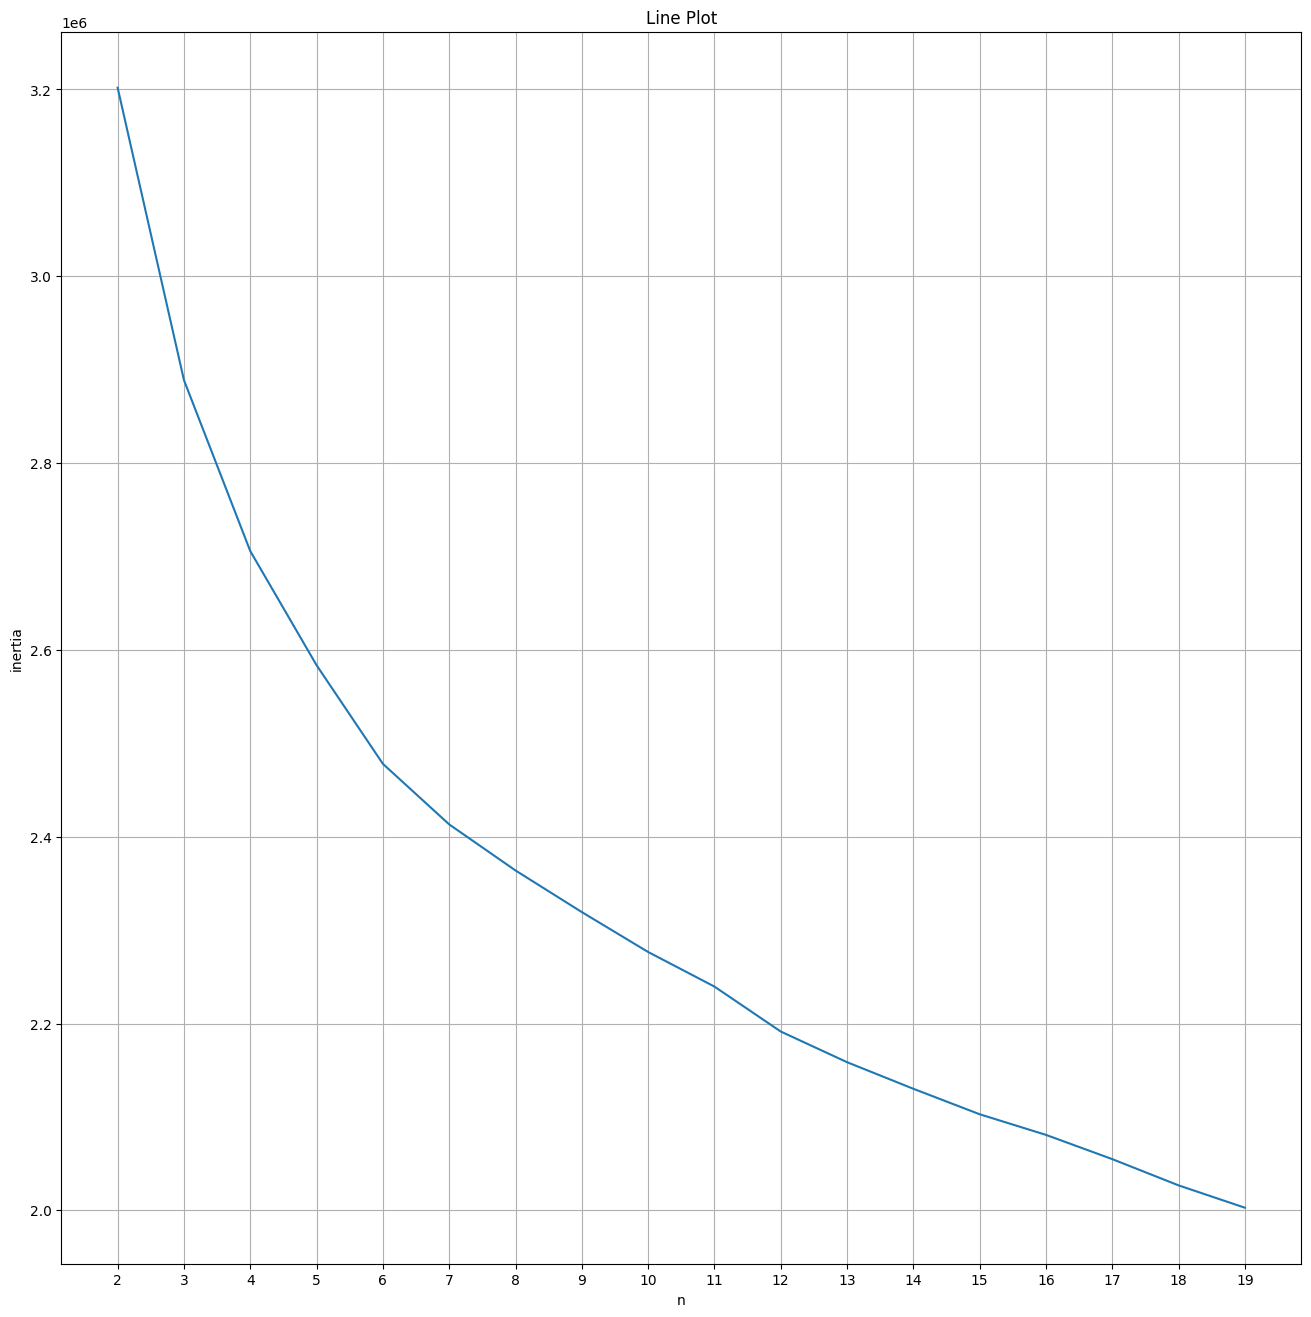

In [31]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='inertia', data=inertia)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_major_formatter(plt.ScalarFormatter())
ax.grid(True)
ax.set_title('Line Plot')
ax.set_xlabel('n')
ax.set_ylabel('inertia')

# Save the plot if needed
# plt.savefig('../results/figures/complete_BIC.pdf')

# Plot results
plt.show()

In [32]:
# Fit the data
n = 4  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init = 10  # the more initializations, the more stable clustering gets

kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=n_init, random_state=0)
fitted = kmeans.fit(data)

labels = kmeans.predict(data)

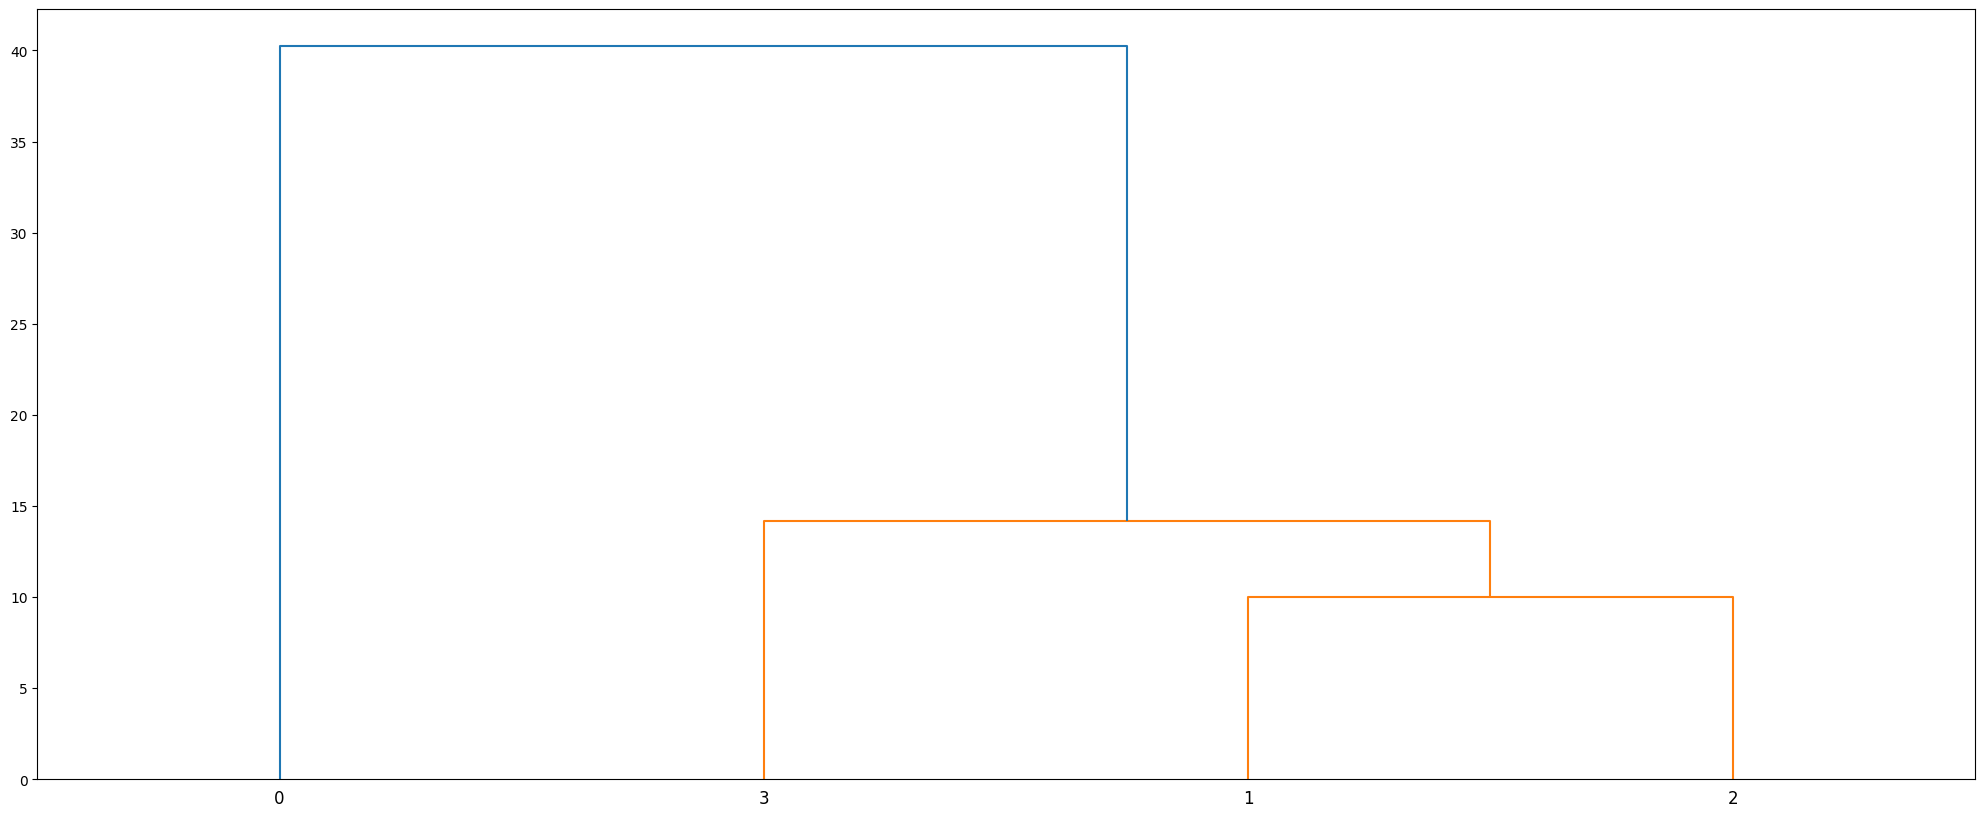

In [33]:
# Dendrogram
group = data.groupby(labels).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

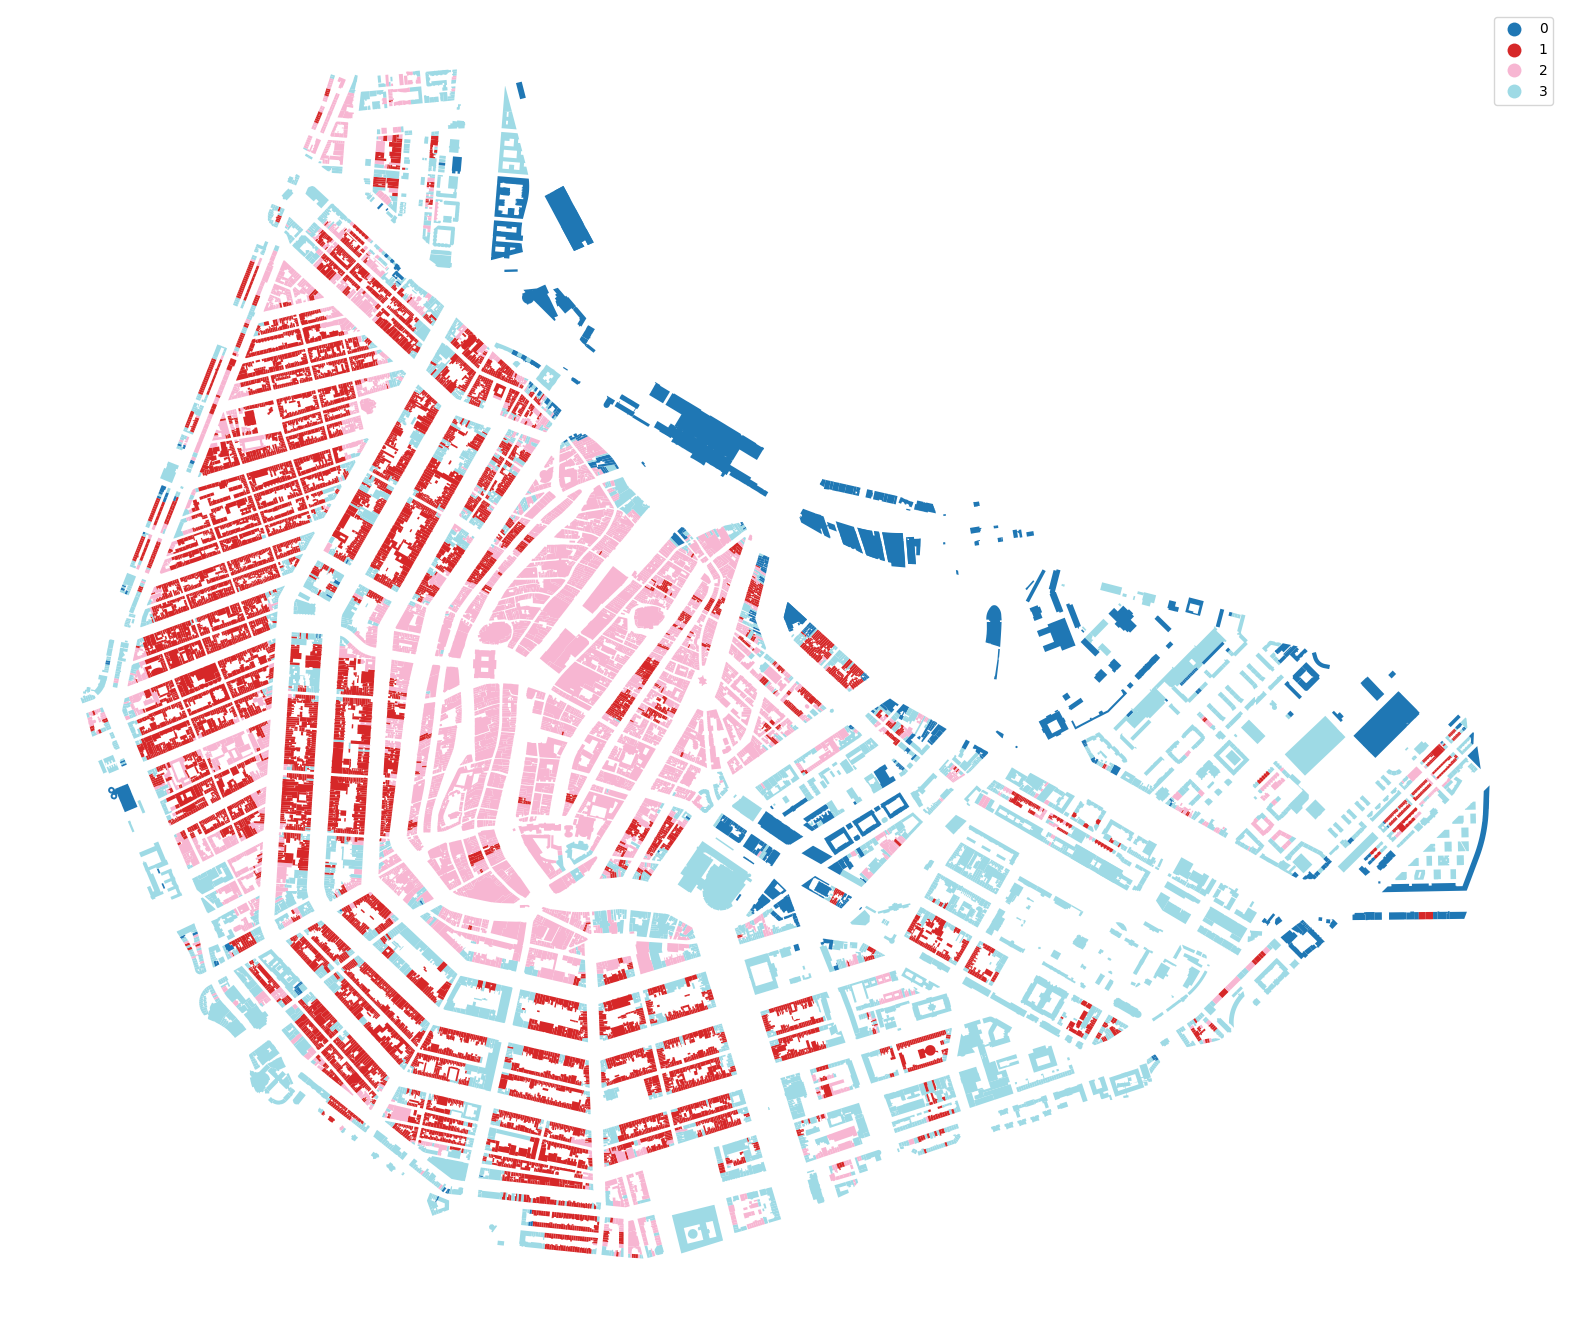

In [34]:
# Plot your results
ax = buildings.plot(labels, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))
ax.set_axis_off()
# plt.savefig('../results/figures/Ams_taxonomy_sample_kmeans.jpg', dpi=600)

## Conclusions

Let's rewind and remember what we did:

There were __3 main hurdles__ to overcome in order to scale this approach:

1. Tessellation
   
   Issue: Original approach not chunkable, because buildings required awareness
   Solution: Changed to two-step approach. 1. Create enclosures using availaible data. 2. Chunk tessellation based on the enclosures, allowing each to be computed independently from each other.
   
3. Calculating contextual indicators

   Issue: A inefficient for-loop caused a slowdown because each row of the dataframe was computed individually
   Solution: Implement dask.delayed. Instead of going row-by-row, we first lazily evaluate the dataframe, collecting the requirements for each row. Then we run the calculation of multiple rows in parallel while capturing the results. Memory intensive, and demands as many workers/threads as one can throw at them.
   
5. Clustering

   Issue: Original clustering algorithm (GMM) is too computationally demanding. Parallel implementation not feasible.
   Solution: Change clustering algorithm to K-means. At scale, we might not have a different choice. Be aware of the trade-offs: sacrificing handling of outliers and different cluster sizes for computational efficiency and simplicity.


### Overall:

- We started with an existing method which worked great and aimed to scale, which caused (solveable) headaches along the way. But we're not yet 100% done, certain characteristics have not been computed.
- If you can, identify the scale at which you need to work first. This will allow you to tailor the methods to this from the onset.






![SegmentLocal](../Documents/images/thanks.gif "segment")